# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'}
url = 'https://charlottesville.craigslist.org/search/boo?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

# Update brands list with popular boat brands
brands = ['bayliner', 'sea ray', 'yamaha', 'lifetime', 'malibu', 'tracker', 'mastercraft',
          'boston whaler', 'crownline', 'hurricane', 'carver', 'tige', 'glastron', 'four winns',
          'alumacraft', 'chaparral', 'rinker', 'moomba', 'lund', 'crestliner', 'centurion',
          'supra', 'regal', 'sun tracker', 'starcraft', 'stingray', 'ranger']

data = [] # We'll save our listings in this object

for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price = listings[k].find('div', class_='price').get_text()
    link = listings[k].find(href=True)['href']

    # Get boat brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title) # Find year references
    if regex_search is None:  # If no hits, record year as missing value
        year = np.nan
    else:  # If hits, record year as first match
        year = regex_search.group(0)

    # Append data to list
    data.append({'title': title, 'price': price, 'year': year, 'link': link, 'brand': brand})

## 2. Get your search results of interest and extract data from them, using code similar to what's above.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_boats.csv') # Save data in case of a disaster
df.head()

(27, 6)


,title,price,year,link,brand,age
0,wave armor drive on pwc and boat ports,2200,NaN,https://charlottesville.craigslist.org/boa/d/g...,missing,NaN
1,john boat 3 trolling motors and battery,800,NaN,https://charlottesville.craigslist.org/boa/d/l...,missing,NaN
2,jon boat and vee bottom boat,200,NaN,https://charlottesville.craigslist.org/boa/d/a...,missing,NaN
3,14ft jon boat crestliner,2850,NaN,https://charlottesville.craigslist.org/boa/d/d...,crestliner,NaN
4,triton tr-175 fishing boat,6500,NaN,https://charlottesville.craigslist.org/boa/d/p...,missing,NaN


With the data in and wrangled, we can now do EDA:

count       27.000000
mean      4805.185185
std       8343.920002
min          0.000000
25%        177.500000
50%        999.000000
75%       5400.000000
max      35000.000000
Name: price, dtype: float64


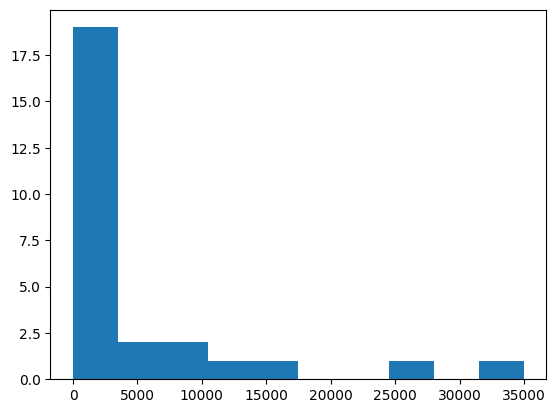

count     3.0
mean     14.0
std       7.0
min       7.0
25%      10.5
50%      14.0
75%      17.5
max      21.0
Name: age, dtype: float64


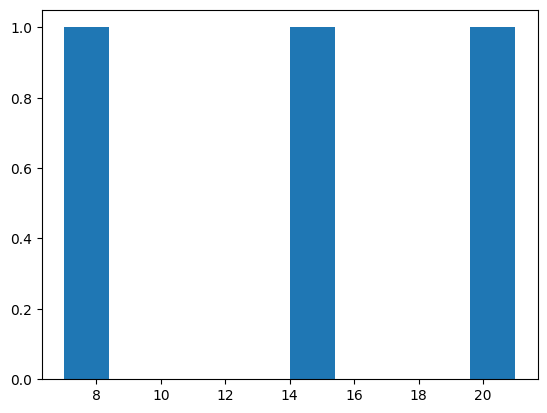

In [5]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                             \
           count     mean          std      min       25%      50%      75%   
brand                                                                         
alumacraft   1.0  35000.0          NaN  35000.0  35000.00  35000.0  35000.0   
crestliner   2.0   8425.0  7884.240610   2850.0   5637.50   8425.0  11212.5   
missing     20.0   2744.5  5791.566677      1.0    173.75    700.0   1750.0   
rinker       2.0   1250.0  1767.766953      0.0    625.00   1250.0   1875.0   
yamaha       2.0  10250.0   353.553391  10000.0  10125.00  10250.0  10375.0   

                     
                max  
brand                
alumacraft  35000.0  
crestliner  14000.0  
missing     25000.0  
rinker       2500.0  
yamaha      10500.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                        
           count  mean std   min   25%   50%   75%   max
brand                                                   
alumacraft   1.0   7.0 NaN   7.0   7.0   7.0   7.0   7.0
crestliner   1.0  14.0 NaN  14.0  14.0  14.0  14.0  14.0
missing      1.0  21.0 NaN  21.0  21.0  21.0  21.0  21.0
rinker       0.0   NaN NaN   NaN   NaN   NaN   NaN   NaN
yamaha       0.0   NaN NaN   NaN   NaN   NaN   NaN   NaN

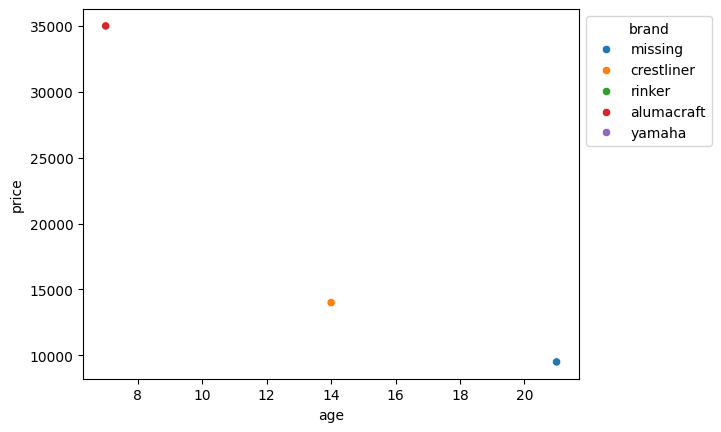

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#I believe a lot of boats don't have their year/age listed so that's why there are so few points in this scatter plot, which makes the scatter plot unhelpful.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   5.360791 -0.370834
log_age    -0.370834  0.308634
           log_price   log_age
log_price   1.000000 -0.996817
log_age    -0.996817  1.000000


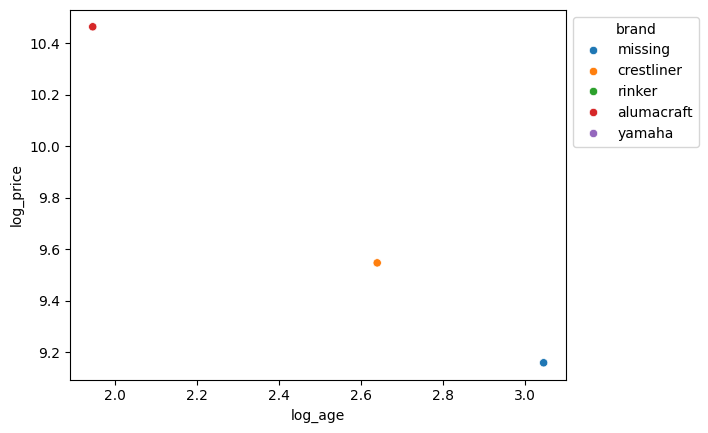

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())
#I believe a lot of boats don't have their year/age listed so that's why there are so few points in this scatter plot, which makes the scatter plot not the most helpful.

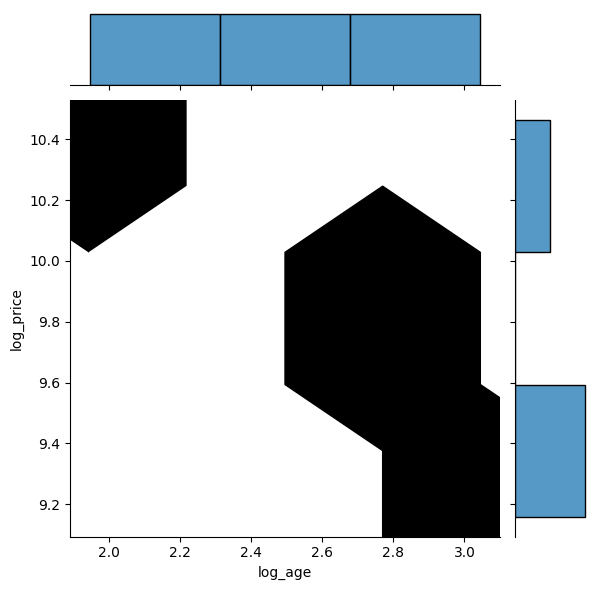

In [10]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')
#Again, the data is limited here, so this plot is not that helpful.

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [11]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links:  # about 3 minutes
    time.sleep(random.randint(1, 3))  # Random delays
    raw = requests.get(link, headers=header)  # Get page
    bsObj = soup(raw.content, 'html.parser')  # Parse the html
    #
    try:
        year_post = bsObj.find(class_='boat-year').get_text()  # Update class name for boat year
    except:
        year_post = np.nan
    #
    try:
        condition = bsObj.find(class_='boat-condition').get_text()  # Update class name for boat condition
    except:
        condition = 'missing'
    #
    try:
        engine_type = bsObj.find(class_='boat-engine-type').get_text()  # Update class name for engine type
    except:
        engine_type = 'missing'
    #
    try:
        length = bsObj.find(class_='boat-length').get_text()  # Update class name for boat length
    except:
        length = 'missing'
    #
    try:
        fuel_type = bsObj.find(class_='boat-fuel-type').get_text()  # Update class name for fuel type
    except:
        fuel_type = 'missing'
    #
    try:
        location = bsObj.find(class_='boat-location').get_text()  # Update class name for location
    except:
        location = 'missing'
    #
    try:
        price = bsObj.find(class_='boat-price').get_text()  # Update class name for price
    except:
        price = 'missing'
    #
    try:
        title = bsObj.find(class_='boat-title').get_text()  # Update class name for title
    except:
        title = 'missing'
    #
    text = bsObj.find(id='postingbody').get_text()  # Adjust if necessary for your site
    text = text.replace('\n', '')
    text = text.replace('QR Code Link to This Post', '')  # Modify or remove as needed

    record = {
        'title': title,
        'year_post': year_post,
        'condition': condition,
        'engine_type': engine_type,
        'length': length,
        'fuel_type': fuel_type,
        'location': location,
        'price': price,
        'text': text,
    }
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [13]:
df.head()

,title,price,year,link,brand,age,log_price,log_age
0,wave armor drive on pwc and boat ports,2200,NaN,https://charlottesville.craigslist.org/boa/d/g...,missing,NaN,7.696213,NaN
1,john boat 3 trolling motors and battery,800,NaN,https://charlottesville.craigslist.org/boa/d/l...,missing,NaN,6.684612,NaN
2,jon boat and vee bottom boat,200,NaN,https://charlottesville.craigslist.org/boa/d/a...,missing,NaN,5.298317,NaN
3,14ft jon boat crestliner,2850,NaN,https://charlottesville.craigslist.org/boa/d/d...,crestliner,NaN,7.955074,NaN
4,triton tr-175 fishing boat,6500,NaN,https://charlottesville.craigslist.org/boa/d/p...,missing,NaN,8.779557,NaN


In [14]:
df['year'].replace('missing', np.nan)

,year
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [15]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df['length'] = df['length'].str.replace(',','')
df['length'] = pd.to_numeric(df['length'],errors='coerce')

df['year_post'] = df['year_post'].str.replace(',','')
df['year_post'] = pd.to_numeric(df['year_post'],errors='coerce')
df.to_csv('craiglist_cville_boats_long.csv')

#The error occurred because the .str accessor in Pandas can only be used with columns containing string values. In this case, the column 'year_post' likely contains non-string values, such as NaN or integers, and in the column 'length',
#all the values are missing and coded as "missing." If a column has mixed data types or contains missing values, the .str methods cannot be applied, causing the AttributeError when attempting to use df['year_post'].str.replace(',', '').

AttributeError: Can only use .str accessor with string values!

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.